### useful functions

In [26]:
import scipy.io as scio
import numpy as np
import pywt
from scipy import signal
from matplotlib import pylab
from pylab import *
from sklearn.metrics import fowlkes_mallows_score
import itertools
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score


In [2]:
def spikedet(signal, threshold):
    detection = []
    for id in range(len(signal)):
        if signal[id] > threshold:
            detection.append(id)
    return detection

def spikedet_peak(signal, threshold):
    peaks = []
    detection = []
    for id in range(len(signal)):
        if signal[id] > threshold:
            detection.append((id,signal[id]))
    #print(maxthresh)        
    for t1, y1 in detection:
        if t1 == 0 or t1 == len(signal) - 1:
            pass
        else:
            if (signal[t1 - 1] < y1) & (signal[t1 + 1] < y1):
                peaks.append(t1)
    return peaks


def neofilter(v,t):
    neo_value = [0 for _ in range(len(t))]
    peaks = []
    #neo calculation
    for i in range(1,len(t)-1):
        neo_value[i] = v[i]*v[i] - v[i-1]*v[i+1]
    neo_value[0] = neo_value[1]
    neo_value[-1] = neo_value[-2]
    return neo_value

def spikefilter(peaks,strip):
    x = np.array(peaks)
    len_old = x.shape[0]
    for i in range(len_old):
        if i >= x.shape[0] - 1:
            break
        for j in range(strip):#11
            if i >= x.shape[0] - 1:
                break
            if (x[i+1] - x[i]) < strip:#原来10，24k
            #if (x[i+1] - x[i]) < 6: #for DWT
                x = np.delete(x,i+1)
    return x

def spikefilter_peak(peaks):
    x = np.array(peaks)
    len_old = x.shape[0]
    for i in range(len_old):
        if i >= x.shape[0] - 1:
            break
        for j in range(2):#11
            if i >= x.shape[0] - 1:
                break
            if (x[i+1] - x[i]) < 20:
            #if (x[i+1] - x[i]) < 6: #for DWT
                x = np.delete(x,i+1)
    return x

def dacalculation(groundtruth,detection):
    TP = FP = FN = 0
    misalignment = 0
    i = j = 0
    while((i<len(groundtruth)) & (j < len(detection))):
        if (detection[j] - groundtruth[i] <= 26) & ((detection[j] - groundtruth[i]) >= 0) : #detection succeeds, true positive, pointer both increases
            TP += 1
            misalignment += detection[j] - groundtruth[i]
            i += 1
            j +=1
        elif(detection[j] - groundtruth[i]) > 26: #a spike is missed, false negtive, only ground truth pointer increase
            FN +=1
            i += 1
        else: #noise is detected, false positive, pointer of detection increase
            FP += 1
            j += 1

    FN = FN + (len(groundtruth) - i)
    FP = FP + (len(detection) - j)
    miss = misalignment/TP
    DA = TP/(TP+FN+FP)
    
#     print("TP,FN,FP,DA:")
#     print(TP,FN,FP,DA)
    return DA,miss

def smoothing(datain,t):
    window = signal.windows.boxcar(5)
    smooth = [0 for _ in range(len(t))]
    for i in range(2,len(t)-2):
        smooth[i] = window[0] * datain[i-2] + window[1] * datain[i-1]+ window[2] * datain[i]+ window[3] * datain[i+1]+ window[4] * datain[i+2]
    smooth[0] = window[2] * datain[0] + window[3] * datain[1]+ window[4] * datain[2]
    smooth[1] = window[1] * datain[0] + window[2] * datain[1] + window[3] * datain[2]+ window[4] * datain[3]
    smooth[-1] = window[0] * datain[-3] + window[1] * datain[-2]+ window[2] * datain[-1]
    smooth[-2] = window[0] * datain[-4] + window[1] * datain[-3] + window[2] * datain[-2]+ window[3] * datain[-1]
    
    return np.array(smooth)


In [3]:
def sigma_calculation(v,sigma_a, G, T):
    #values = []
    num = 0
    ratio = 0
    #sigma_a = 0.5 #initial number, not sure the set value
    sigma_t = 0.3173
#     for t,y in v:
#         values.append(y)
#     std = np.std(values)
    for y in v:
        if abs(y) > sigma_a:
            num += 1
    ratio = num/len(v)
    error = ratio - sigma_t
    new_sigma_a = sigma_a + G * T * error
    return new_sigma_a

In [4]:
def energyop(v,t):
    neo_value = [0 for _ in range(len(t))]
    peaks = []
    #neo calculation
    for i in range(1,len(t)-1):
        neo_value[i] = abs(v[i]*(v[i]-v[i-1]))
    neo_value[0] = neo_value[1]
    neo_value[-1] = neo_value[-2]
    return neo_value

# Dataset: C_Easy2 & Difficult 1 & Difficult 2

### prepare data

In [5]:
names = locals()
for w in ['005','01','015','02']:
#     names['dataFile_e2'+str(w)] = '../../Simulator/C_Easy2_noise'+ str(w)+'.mat'
#     names['dataFile_d1'+str(w)] = '../../Simulator/C_Difficult1_noise'+ str(w)+'.mat'
#     names['dataFile_d2'+str(w)] = '../../Simulator/C_Difficult2_noise'+ str(w)+'.mat'
    names['dataFile_e2'+str(w)] = '.\Simulator\C_Easy2_noise'+ str(w)+'.mat'
    names['dataFile_e1'+str(w)] = '.\Simulator\C_Easy1_noise'+ str(w)+'.mat'
    names['dataFile_d1'+str(w)] = '.\Simulator\C_Difficult1_noise'+ str(w)+'.mat'
    names['dataFile_d2'+str(w)] = '.\Simulator\C_Difficult2_noise'+ str(w)+'.mat'# path is needed to be changed
    names['data_e1'+str(w)],names['data_e2'+str(w)],names['data_d1'+str(w)],names['data_d2'+str(w)] = scio.loadmat(names['dataFile_e1'+str(w)]),scio.loadmat(names['dataFile_e2'+str(w)]),scio.loadmat(names['dataFile_d1'+str(w)]),scio.loadmat(names['dataFile_d2'+str(w)])
    names['spikes_e1'+str(w)],names['spikes_e2'+str(w)],names['spikes_d1'+str(w)],names['spikes_d2'+str(w)] =  names['data_e1'+str(w)]['data'][0], names['data_e2'+str(w)]['data'][0],names['data_d1'+str(w)]['data'][0],names['data_d2'+str(w)]['data'][0]
    names['index_e1'+str(w)] = names['index_e2'+str(w)] = names['index_d1'+str(w)] = names['index_d2'+str(w)] = np.array(range(len(names['spikes_e2'+str(w)])))#[:960000]

In [6]:
spikes_e1005[0]

-0.05265172224971963

In [7]:
converg = 20
scaling = 1/1024
cnt = 0
data = spikes_e1005
sigma = 0
sigma_reg = [0]
for i in range(5000):
    for j in range(256):
        if (data[j+i*256] >= sigma):
            cnt+=1
    diff = cnt - converg
    print(diff)
    cnt = 0
    sigma = sigma + diff * scaling
    sigma_reg.append(sigma)

120
3
-14
-14
-20
20
-3
-2
-1
-13
25
-6
-9
3
-14
-5
-6
47
0
-20
-18
6
12
-7
32
-8
7
-14
-9
-4
-8
-16
12
-11
29
-5
-4
2
-10
29
-16
3
-12
-6
9
-10
-7
-3
21
-7
18
-13
-5
-16
-12
50
-13
4
-17
-1
25
0
-2
-11
-15
-5
-8
2
4
-5
17
39
-19
-4
11
-2
-20
9
-10
5
-20
27
-7
-20
-4
15
11
-3
-14
12
7
-14
3
17
15
-15
-10
1
-13
5
12
1
-11
-15
20
1
-11
22
-17
-1
0
47
-17
-6
-20
4
-14
29
-7
4
-5
-20
18
15
6
-13
-4
-7
1
-20
-6
16
4
-10
-18
2
45
-7
-12
-12
-6
22
27
-20
-20
-20
9
45
5
-15
-16
3
-4
5
9
3
-20
-9
16
17
29
1
-7
-11
0
-5
10
-13
-17
3
1
-7
-6
24
-11
15
-13
-18
15
14
9
-18
-8
-4
2
-3
-8
7
-5
20
2
-7
-3
-1
1
3
-17
-11
23
-18
14
32
-1
-14
-16
11
-15
-20
5
32
6
-15
-13
15
-6
4
-12
6
16
-15
-1
4
-7
-17
5
7
11
-19
38
5
-16
19
-20
-14
-2
-1
-13
8
3
0
11
17
-20
-15
25
-1
-13
5
-14
-10
42
-20
-20
-8
-20
-3
58
-19
-8
28
12
-9
1
-2
-20
-4
33
-16
4
23
-8
-20
-17
0
-7
29
20
-2
-16
0
-20
0
15
-9
8
-2
-5
-3
-15
-3
25
16
-9
2
4
-15
-6
-13
40
-9
-3
-8
3
-11
41
-12
-20
15
-3
-18
11
2
-13
20
6
-16
-14
11
-10
9
19
-1

14
-12
20
-9
-6
-11
11
1
11
-1
-16
15
29
-16
-11
-20
-10
8
-17
38
-5
1
-11
-10
5
24
-10
36
-20
-6
4
-20
-7
-13
13
5
0
-3
35
-7
-13
-20
-15
29
-12
-2
44
-16
-13
-4
1
-12
-20
28
-3
-12
-10
-3
-2
33
36
-20
-16
-12
0
-3
11
5
-1
-9
-14
14
2
-16
6
31
-19
-6
14
-18
-17
39
-13
-10
7
0
10
2
-9
-5
23
5
-20
-11
37
-12
-16
-14
-7
42
-11
-15
-8
21
-20
4
8
1
7
-20
-8
-19
49
-4
10
2
9
-14
-13
-6
-4
6
-2
-20
2
4
10
21
-3
-20
12
-8
27
16
-5
2
5
-7
-5
-14
-5
-5
-11
17
-8
-17
20
-15
37
-20
-6
13
-11
-15
4
33
-7
-7
13
-20
-8
12
-20
5
-4
2
50
-19
27
-1
-20
-13
-16
-8
-18
0
7
-7
45
-10
-7
20
-4
-18
7
13
-4
-8
-6
-2
9
-9
-1
-7
16
-9
4
9
-3
7
-5
8
3
-7
10
-8
14
-1
-16
2
-11
10
-8
4
-10
-1
-3
37
6
-20
-20
28
-14
-10
-13
25
-1
4
-8
-8
-10
-9
31
-9
-20
1
9
-1
-9
41
6
-13
17
-19
-9
17
4
-17
-4
-20
15
3
-5
-2
-5
-17
22
0
-16
79
-20
-20
0
-17
14
-4
0
-7
-5
-5
1
-16
3
-5
31
13
-11
-4
0
-1
-3
-16
-13
69
-14
-12
11
-11
11
-14
7
3
-13
17
-20
-14
-17
7
-4
17
18
-20
-8
11
10
-4
3
-14
-13
17
10
11
-3
-16
-16
1
-14
0
13
-1

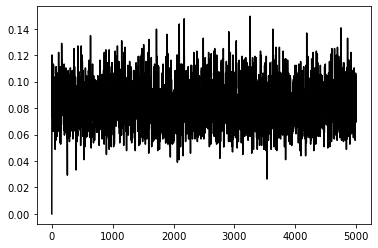

In [8]:
plt.figure()
plt.plot(index_e1005[:5000],sigma_reg[:5000],color = 'black')
# scatter([x for x, y in peaks2s[600:]], [y for x, y in peaks2s[600:]], color = 'red')
#scatter(spike_times[-2], y[-2], color = 'red')
# plt.xlabel('time interval(41.7us/sample)')
# plt.ylabel('microvolts (uV)')
#plt.title("detected points")
#plt.savefig('detections.jpg',dpi=400, transparent=True)
plt.show()

### spike detection


# new block diagramm

In [9]:
for w in ['005','01','015','02']:
    for j in ['e1','e2','d1','d2']:
        #1st wavelet transformation
        (names['cA1_'+str(j)+str(w)], names['cD1_'+str(j)+str(w)]) = pywt.swt(names['spikes_'+str(j)+str(w)],'haar',1)[0]
        #2nd TEO
        #names['teo1_'+str(j)++str(w)] = neofilter(names['cD2_'+str(j)++str(w)], names['index_'+str(j)+str(w)])
        names['teo2_'+str(j)+str(w)] = neofilter(names['cA1_'+str(j)+str(w)], names['index_'+str(j)+str(w)])
        names['spiketeo_'+str(j)+str(w)] = neofilter(names['spikes_'+str(j)+str(w)], names['index_'+str(j)+str(w)])
        if w == '02':
            c = 0.3 #0.4 and 0.5 for 0r gate
        elif w == '0.15':
            c = 0.35
        elif w == '0.1':
            c = 0.4
        else:
            c = 0.45
        #threshold calculation
        names['threshold2_'+str(j)+str(w)] = c*np.std(names['cA1_'+str(j)+str(w)][:10000])
        names['threshold3_'+str(j)+str(w)] = 0.3*np.std(names['spikes_'+str(j)+str(w)][:10000])

        #spike detection
        #names['peaks1_'+str(j)++str(w)] = spikedet(names['smooth1_'+str(j)++str(w)], names['threshold1_'+str(j)++str(w)])
        names['peaks2_'+str(j)+str(w)] = spikedet(names['teo2_'+str(j)+str(w)], names['threshold2_'+str(j)+str(w)])
        names['peaks3_'+str(j)+str(w)] = spikedet(names['spiketeo_'+str(j)+str(w)], names['threshold3_'+str(j)+str(w)])

In [10]:
from functools import reduce
for w in ['005','01','015','02']:
    for i in ['e1','e2','d1','d2']:
        if w == '02':
            s = 11
        else:
            s = 10
        names['peaks_res_'+str(i)+str(w)] = np.intersect1d(names['peaks2_'+str(i)+str(w)], names['peaks3_'+str(i)+str(w)])
        names['detections'+str(i)+str(w)] = spikefilter(names['peaks_res_'+str(i)+str(w)],s)
        #names['detections'+str(i)+str(w)] = names['peaks_res_'+str(i)+str(w)])
        #np.union1d or np.intersect1d

In [22]:

signals = list(map(lambda x: data_e1005['data'][0][x-5:x+20],detectionse1005))

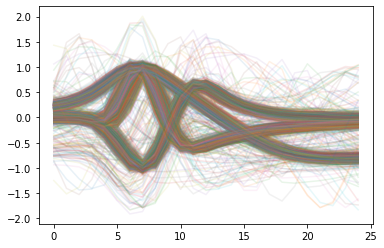

In [23]:
for i in range(len(signals)):
    plt.plot(range(len(signals[i])),signals[i],alpha=0.1)

## Sorting

In [24]:
class Osorter:
    def __init__(self,distance,threshold,update):
        self.distance = distance
        self.threshold= threshold
        self.cluster_means=[]
        self.cluster_cardinality = []
        self.update=update
    
    def closest_cluster(self,signal,test=False):
        min_dist= float("inf")
        for i,center in enumerate(self.cluster_means):
            if(self.cluster_cardinality[i]==-1):
                continue
            if(test and self.cluster_cardinality[i]<np.sum(self.cluster_cardinality)*0.02):
                continue
            dist = self.distance(signal,center)
            if(dist<min_dist):
                min_dist=dist
                ind= i
        if(test):
            try:
                return ind
            except:
                return -1
        if(min_dist<self.threshold):
            return ind
        else:
            return len(self.cluster_means)
        
    def train(self,signal,test=False):
        if(len(self.cluster_means)==0):
            self.cluster_means.append(signal)
            self.cluster_cardinality.append(1)
            return 0
        cluster = self.closest_cluster(signal,test)
        if(cluster==len(self.cluster_means)):
            self.cluster_means.append(signal)
            self.cluster_cardinality.append(1)
            return cluster
        self.cluster_cardinality[cluster]=self.cluster_cardinality[cluster]+1
        self.cluster_means[cluster] =self.update(self.cluster_cardinality[cluster],self.cluster_means[cluster],signal)       
                

        return cluster
    def get_centroids(self):
        return self.cluster_means
        
                
        
        

In [25]:
exact_update = lambda card,mean,signal:  ((card-1) * mean + signal)/card
approx_update = lambda card,mean,signal: mean + (-mean + signal)/2**(np.ceil(max(np.log2(card+1),256)))

In [27]:
def hypertune(params,data,gt,update,merging=False):
    keys, values = zip(*params.items())
    permutations_dict = [dict(zip(keys, v)) for v in itertools.product(*values)]
    max_score = 0
    best_sil = -1
    best_sil_param=-1
    X_train, X_test, y_train, y_test = train_test_split(data, gt, test_size=0.2,shuffle=True)
    for param in tqdm(permutations_dict):
        sorter = Osorter(param['distance'],param['thresh'],update)
        c_hat = np.array([sorter.train(x) for x in X_train])
        c_hat = np.array([sorter.train(x,test=True) for x in X_test])
        score = fowlkes_mallows_score(y_test,c_hat)
        if(len(set(c_hat))>1):
            sil = silhouette_score(X_test,c_hat)
            if(sil>best_sil):
                best_sil=sil
                best_sil_param =param['thresh']
                best_f_score = score
                nb_cls = len(set(c_hat))
        if score>max_score and (-1) not in set(c_hat):
            best_sorter = sorter
            max_score = score
            best_param = param
            centroids = [best_sorter.cluster_means[i] for i in list(set(c_hat))]
            'print(Counter(c_hat))'
            best_pred = c_hat
    rng = range(len(X_test[0]))
    colors= ['r','b','g','y','w','k','c','m']
    color_dict={}
    i=0
    for v in list(set(best_pred)):
        color_dict[v] = colors[i]
        i+=1
    plt.figure()
    fig,axs = plt.subplots(1,2, figsize=(15, 5))
    for i in range(len(X_test)):
        axs[0].plot(rng,X_test[i],c= color_dict[best_pred[i]],alpha=.1)
        axs[0].set_title('predictions')
    for i in range(len(X_test)):
        axs[1].plot(rng,X_test[i],c='rgbk'[y_test[i]-1],alpha=.1)
        axs[1].set_title('groud truth')
    plt.show()

    print('best_param_silhoutte = ', best_sil_param, ", with score=", best_f_score, ", nb clusters = ",nb_cls)
    return best_param,max_score,centroids

<Figure size 432x288 with 0 Axes>

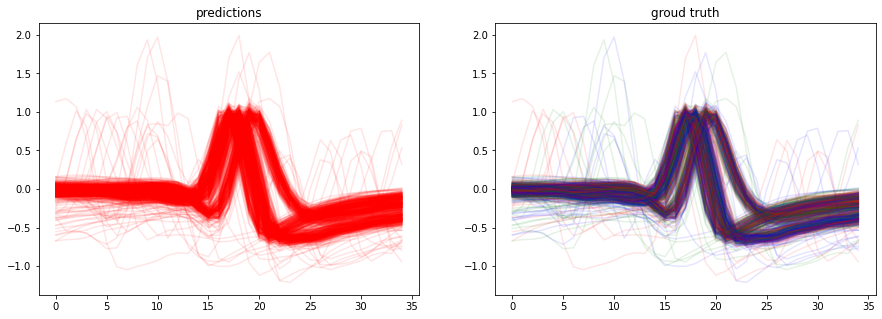

best_param_silhoutte =  12.484848484848484 , with score= 0.41138037530913996 , nb clusters =  3
L1 best parmaeters =  15.318181818181818 with score =  0.5766105277683614


ValueError: Found input variables with inconsistent numbers of samples: [3429, 3448]

In [38]:
l1_params = {
    'distance':[lambda x,y:  np.linalg.norm(x-y,ord=1)],
    'thresh': np.linspace(4.5,30,100),
}
datasets =[[data_d1005,data_d101,data_d1015,data_d102]]
times = [[detectionsd1005,detectionsd101,detectionsd1015,detectionsd102]]
best_scores_exact = []
best_thresh_exact = []
best_centroids =[]
for i in range(len(datasets)):
    scores = []
    thresh=[]
    means = []
    for j  in range(len(datasets[i])):
        signals = list(map(lambda x: datasets[i][j]['data'][0][x-15:x+20],times[i][j]))
        gt = datasets[i][j]['spike_class'][0][0][0]
        l1_best,l1_score,best_means = hypertune(l1_params,signals,gt,exact_update,False)
        means.append(best_means)
        scores.append(l1_score)
        thresh.append(l1_best['thresh'])
        print('L1 best parmaeters = ', l1_best['thresh'], 'with score = ',l1_score)
    best_centroids.append(means)
    best_scores_exact.append(scores)
    best_thresh_exact.append(thresh)